In [1]:
import anndata as ad
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json
import ccf_streamlines.projection as ccfproj

import sys
# import ../utils
sys.path.append('../')
from utils import reflect_points_to_left

### Get flatmap lines and area annotations

In [2]:
data_dir = os.environ.get('ROOT_DATA_PATH')
ccf_files_path = os.path.join(data_dir, "CCF_files")

space = "flatmap_butterfly"
bf_boundary_finder = ccfproj.BoundaryFinder(
    projected_atlas_file=    os.path.join(ccf_files_path,f"{space}.nrrd"),
    labels_file=    os.path.join(ccf_files_path,"labelDescription_ITKSNAPColor.txt"),
)
bf_left_boundaries_flat = bf_boundary_finder.region_boundaries()


# move up the hierarchy to get rid of the smallest 'areas' which are actually layers
with open('../../data/files/area_ancestor_id_map.json', 'r') as f:
    area_ancestor_id_map = json.load(f)
with open('../../data/files/area_name_map.json', 'r') as f:
    area_name_map = json.load(f)
area_name_map['0'] = 'outside_brain'
annotation2area_int = {0.0:0} # Map from annotation id to area id. Float to int
for a in area_ancestor_id_map.keys(): 
    higher_area_id = area_ancestor_id_map[str(int(a))][1] if len(area_ancestor_id_map[str(int(a))])>1 else a    
    annotation2area_int[float(a)] = higher_area_id

unique_areas = np.unique(list(annotation2area_int.values())) # List of unique areas (noncontiguous ints)
unique_annos = [area_name_map[str(int(a))] for a in unique_areas] # List of unique area names
area_classes = np.arange(len(unique_areas)) # Create a class for each area (0, 1, 2, ...)
id2id = {float(k):v for (k,v) in zip(unique_areas, area_classes)} # Map from area id to class id
annoation2area_class = {k: id2id[int(v)] for k,v in annotation2area_int.items()} # Map from annotation to area class
id2id_rev = {v:k for k,v in id2id.items()} # Map from class id to area id
area_class2area_name = {k: area_name_map[str(int(v))] for k,v in id2id_rev.items()} # Map from area class to area name




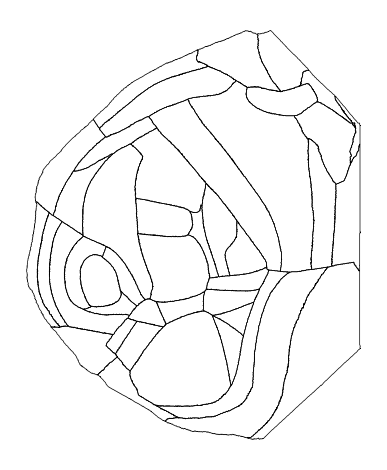

In [3]:
for k, boundary_coords in bf_left_boundaries_flat.items():
    plt.plot(*boundary_coords.T, c="k", lw=0.5)

ax = plt.gca()
ax.invert_yaxis()

plt.axis('off')
# plt.grid()
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.savefig("boundaries.png")

## Fig 2a

Slices and 4 flatmap brains

In [4]:
#get system variable
data_dir = os.environ.get('ROOT_DATA_PATH')

## Even numbered brains are controls; odd numbered brains are enucleated
animals = ["filt_neurons_D076_1L_CCFv2_newtypes.h5ad",
    "filt_neurons_D077_1L_CCFv2_newtypes.h5ad",
    # "filt_neurons_D077_2L_CCFv2_newtypes.h5ad",
    "filt_neurons_D078_1L_CCFv2_newtypes.h5ad",
    # "filt_neurons_D078_2L_CCFv2_newtypes.h5ad",
    "filt_neurons_D079_3L_CCFv2_newtypes.h5ad",
    # "filt_neurons_D079_4L_CCFv2_newtypes.h5ad"
    ]


In [5]:

#load data
adata_list = []
for animal in animals:
    adata = ad.read_h5ad(os.path.join(data_dir, 'barseq/Chen2023', animal), backed='r')
    animal_name = '_'.join(animal.split('_')[2:4])
    adata.obs['CCFano'] = adata.obs['CCFano'].astype('category')
    adata.obs['CFFname'] = adata.obs['CCFname'].astype('category')
    adata.obs['area_label'] = adata.obs['CCFano'].map(annoation2area_class).astype('category')
    adata.obs['area_name'] = adata.obs['area_label'].map(area_class2area_name).astype('category')

    # remove cells in the 'outside_brain' area
    adata = adata[adata.obs['area_name'] != 'outside_brain']
    adata_list.append(adata)

In [6]:
def create_master_colormap(adata_list):
    all_categories = set()
    label_names = None
    # Get unique categories from all datasets
    for adata in adata_list:
        all_categories.update(adata.obs['area_name'].unique())
        if label_names is None:
            # Using area_class2area_name for label names since it's our mapping dictionary
            label_names = area_class2area_name
    # Convert to sorted list for consistent ordering
    all_categories = sorted(list(all_categories))
    
    # Create extended colormap by combining multiple colorschemes
    colormaps = ['tab20', 'tab20b', 'tab20c']
    colors = np.vstack([plt.cm.get_cmap(cmap)(np.linspace(0, 1, 20)) for cmap in colormaps])
    
    # Map categories to colors
    color_indices = np.arange(len(all_categories)) % len(colors)
    color_map = dict(zip(all_categories, colors[color_indices]))
    
    return color_map, label_names

master_colormap, label_names = create_master_colormap(adata_list)

/tmp/ipykernel_4030489/4158423469.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = np.vstack([plt.cm.get_cmap(cmap)(np.linspace(0, 1, 20)) for cmap in colormaps])


Slicse

/tmp/ipykernel_4030489/1225256940.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(df_slice, x='x', y='y', c='gray', palette='tab20', alpha=1, s=2)


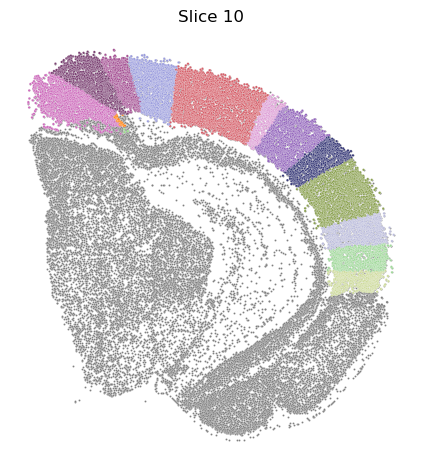

/tmp/ipykernel_4030489/1225256940.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(df_slice, x='x', y='y', c='gray', palette='tab20', alpha=1, s=2)


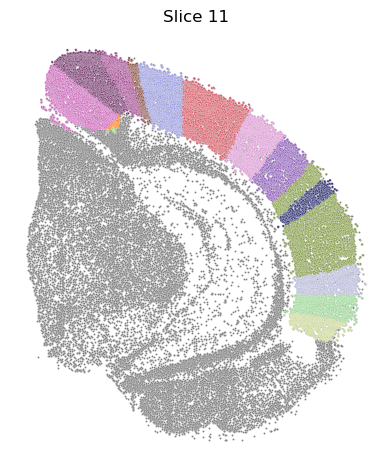

/tmp/ipykernel_4030489/1225256940.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(df_slice, x='x', y='y', c='gray', palette='tab20', alpha=1, s=2)


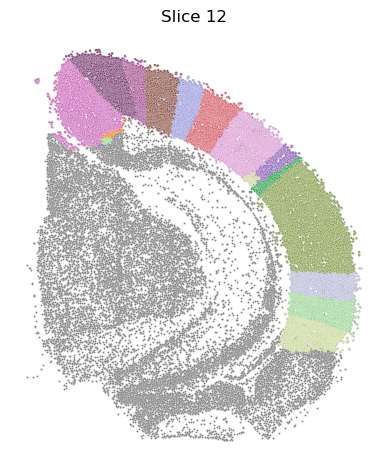

/tmp/ipykernel_4030489/1225256940.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(df_slice, x='x', y='y', c='gray', palette='tab20', alpha=1, s=2)


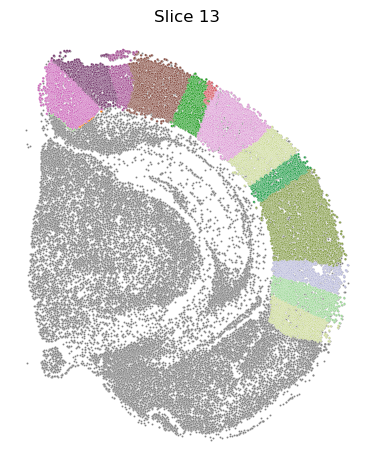

/tmp/ipykernel_4030489/1225256940.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(df_slice, x='x', y='y', c='gray', palette='tab20', alpha=1, s=2)


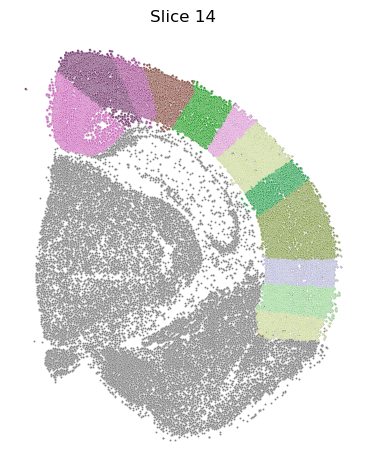

/tmp/ipykernel_4030489/1225256940.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(df_slice, x='x', y='y', c='gray', palette='tab20', alpha=1, s=2)


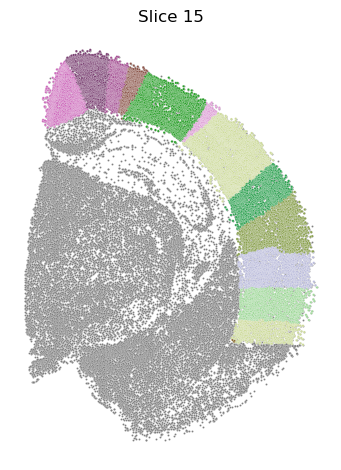

/tmp/ipykernel_4030489/1225256940.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(df_slice, x='x', y='y', c='gray', palette='tab20', alpha=1, s=2)


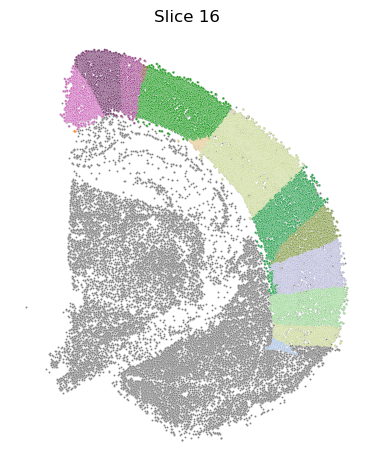

/tmp/ipykernel_4030489/1225256940.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(df_slice, x='x', y='y', c='gray', palette='tab20', alpha=1, s=2)


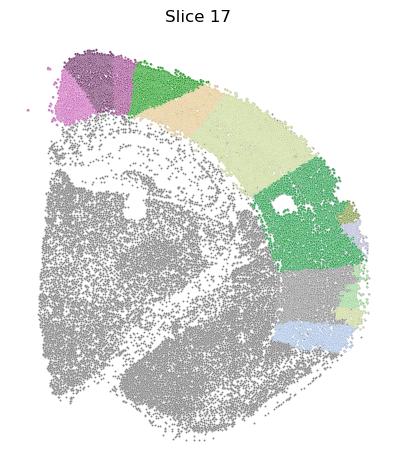

/tmp/ipykernel_4030489/1225256940.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(df_slice, x='x', y='y', c='gray', palette='tab20', alpha=1, s=2)


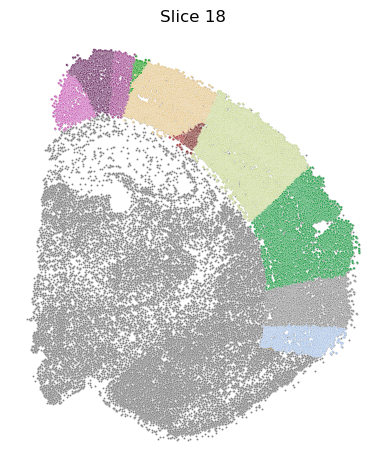

/tmp/ipykernel_4030489/1225256940.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(df_slice, x='x', y='y', c='gray', palette='tab20', alpha=1, s=2)


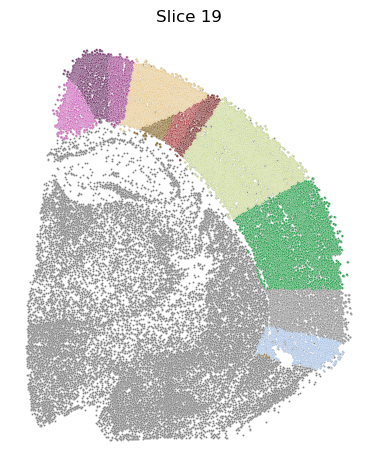

In [7]:
adata = adata_list[0]

xy = adata.obsm['pos']
df = pd.DataFrame(xy, columns=['x', 'y'])
df['CCFano'] = adata.obs['CCFano'].values
df['area_name'] = adata.obs['area_name'].values
df['slice'] = adata.obs['slice'].values

subcortical_mask = np.isnan(adata.obsm['CCF_streamlines']).any(axis=1)


for slice in range(10,20):
    df_slice = df[df['slice'] == slice]

    sns.scatterplot(df_slice, x='x', y='y', c='gray', palette='tab20', alpha=1, s=2)

    df_in_slice_and_subcortical = df[(df['slice'] == slice) & ~subcortical_mask]
    sns.scatterplot(df_in_slice_and_subcortical, x='x', y='y', hue='area_name', palette=master_colormap, alpha=1, s=3)

    plt.axis('off')
    # plt.grid()
    plt.title(f"Slice {slice}")
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.legend().remove()  # This completely removes the legend
    plt.tight_layout()
    plt.savefig(f"slice_{slice}.png", dpi=100, transparent=True, facecolor='none')
    plt.show()


Now the flatmap for all animals

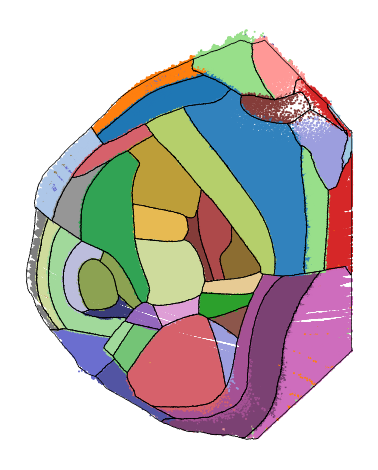

In [11]:

#load data
for i,adata in enumerate(adata_list):

    animal = animals[i]
    animal_name = '_'.join(animal.split('_')[2:4])
    
    xyz = adata.obsm['CCF_streamlines']
    xyz = reflect_points_to_left(xyz)

    df = pd.DataFrame(xyz, columns=['x', 'y','z'])

    df['CCFano'] = adata.obs['CCFano'].values
    df['area_name'] = adata.obs['area_name'].values

    # downsample df
    # df = df.iloc[::5]
    sns.scatterplot(df, x='x', y='y', hue='area_name', palette=master_colormap, alpha=1, s=2, linewidth=0, edgecolor=None)
    # plt.title(animal_name)

for k, boundary_coords in bf_left_boundaries_flat.items():
    plt.plot(*boundary_coords.T, c="k", lw=0.5)

# invert y axis
ax = plt.gca()
ax.invert_yaxis()
plt.legend().remove()  # This completely removes the legend

plt.axis('off')
# plt.grid()
plt.gca().set_aspect('equal')
plt.tight_layout()

plt.savefig(f'flatmap_areas_all.png', dpi=300, transparent=True, facecolor='none')
plt.show()
